In [59]:
# Step 1: Import Necessary Libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import nibabel as nib
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass
from sklearn.model_selection import train_test_split


In [60]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
GPU details:  {'compute_capability': (8, 9), 'device_name': 'NVIDIA RTX 4000 Ada Generation'}


### NOTE: SITE '2' and '7' ARE NOT AVAILABLE

In [61]:
# path = '/home/zaz22/research-data-store/fmri'
# for root, dirs, files in os.walk(path):
#     print(f"Directory: {root}, Number of files: {len(files)}")

In [62]:
site_mapping = {
    1: "Peking University",
    3: "Kennedy Krieger Institute",
    4: "NeuroIMAGE Sample",
    5: "New York University Child Study Center",
    6: "Oregon Health & Science University",
    8: "Washington University in St. Louis"
}

In [63]:
# Path to the main folder containing all the sites (use absolute path if needed)
main_folder = '/home/zaz22/research-data-store/fmri'  # Replace with the full path if necessary

# Initialize the dictionary to store subject filenames by site
site_subject_dict = {}

# Traverse the folder structure and collect file names
print(f"Scanning directory: {main_folder}")  # Debug statement

for root, dirs, files in os.walk(main_folder):
    if files:  # Ensure there are files in the current directory
        site = os.path.basename(root)  # Get the site name (e.g., 'fmri_beijing')
        # Filter for relevant file types (e.g., .nii.gz)
        relevant_files = [file for file in files if file.endswith('.nii.gz')]

        if relevant_files:  # Only process if there are relevant files
            if site not in site_subject_dict:
                site_subject_dict[site] = []  # Initialize the list if site not in dictionary

            # Add the filenames to the site list
            site_subject_dict[site].extend(relevant_files)

# Print the dictionary summary to verify
if site_subject_dict:
    for site, filenames in site_subject_dict.items():
        print(f"{site}: {len(filenames)} files")
else:
    print("No relevant files found.")


Scanning directory: /home/zaz22/research-data-store/fmri
fmri_beijing: 194 files
fmri_nyu: 396 files
fmri_ohsu: 237 files
fmri_neuroimage: 48 files
fmri_kki: 83 files
fmri_washu: 124 files


In [64]:
rois_folder = '/home/zaz22/research-data-store/rois'  # Path to the rois folder

# Initialize a dictionary to map site folders to their respective ROI files
site_roi_files = {}

# Iterate through the directories in 'rois' and map them to the fmri directory
for site_folder in os.listdir(rois_folder):
    site_path = os.path.join(rois_folder, site_folder)
    if os.path.isdir(site_path):
        roi_path = os.path.join(site_path, 'rois', 'brain_rois.mnc.gz')  # Adjust as needed for file extensions
        if os.path.exists(roi_path):
            site_name = site_folder.replace('rois_3000_', '')  # Extract the site name from the folder
            site_roi_files[site_name] = roi_path

# Print the mapping for verification
print(f'Mapped site ROI files: {site_roi_files}')

# Initialize a list to store time series for all subjects
all_tseries = []

from nilearn.maskers import NiftiLabelsMasker

# Iterate through each site and process the corresponding fMRI data
for site_name, roi_file in site_roi_files.items():
    if f'fmri_{site_name}' in site_subject_dict:
        site_subject_files = site_subject_dict[f'fmri_{site_name}']
        
        # Load the ROI mapping image
        mapping_img = nib.load(roi_file)
        mapping_data = mapping_img.get_fdata()
        affine = mapping_img.affine
        
        # Get the unique labels (excluding 0)
        roi_labels = np.unique(mapping_data)
        roi_labels = roi_labels[roi_labels != 0]
        n_rois = len(roi_labels)
        
        print(f'Site: {site_name} | Number of ROIs: {n_rois}')
        
        # Create a masker for extracting time series from ROIs
        labels_masker = NiftiLabelsMasker(
            labels_img=mapping_img,
            standardize=True,
            detrend=True,
            t_r=2.0,  # Replace with your TR (repetition time)
            verbose=1
        )
        
        for func_file_name in site_subject_files:
            func_file_path = os.path.join(main_folder, f'fmri_{site_name}', func_file_name)
            sub_id = func_file_name.split('_')[2]  # Adjust split as needed to extract subject ID
            print(f'Loading functional image for {sub_id} from {func_file_path}')
            
            # Load the functional image
            func_img = nib.load(func_file_path)
            
            # Extract time series using the labels masker
            tseries = labels_masker.fit_transform(func_img)
            
            all_tseries.append(tseries)
            
            print(f'Extracted time series for {sub_id} with shape {tseries.shape}')


Mapped site ROI files: {'washu': '/home/zaz22/research-data-store/rois/rois_3000_washu/rois/brain_rois.mnc.gz', 'kki': '/home/zaz22/research-data-store/rois/rois_3000_kki/rois/brain_rois.mnc.gz'}
Site: washu | Number of ROIs: 2843
Loading functional image for 0015033 from /home/zaz22/research-data-store/fmri/fmri_washu/fmri_X_0015033_session_1_run1.nii.gz
[NiftiLabelsMasker.wrapped] loading data from Minc1Image('/home/zaz22/research-data-store/rois/rois_3000_washu/rois/brain_rois.mnc.gz')
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image('/home/zaz22/research-data-store/fmri/fmri_washu/fmri_X_0015033_session_1_run1.nii.gz')
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Extracted time series for 0015033 with shape (132, 2843)
Loading functional image for 0015054 from /home/zaz22/research-data-store/fmri/fmri_washu/fmri_X_0015054_session_1_run1.nii.gz
[NiftiL

In [65]:
# Step 4: Extract ROI Coordinates (Same as Before)

# Extract ROI coordinates (center of mass)
roi_coords = []

for label in roi_labels:
    # Create a binary mask for the current ROI
    roi_mask = mapping_data == label

    # Calculate the center of mass in voxel space
    com_voxel = center_of_mass(roi_mask)

    # Convert voxel coordinates to world coordinates using the affine matrix
    com_world = nib.affines.apply_affine(affine, com_voxel)

    roi_coords.append(com_world)


In [66]:
# Step 5: Verify Alignment Between Time Series and ROI Labels

n_subjects = len(all_tseries)

# Check that all time series have the same number of ROIs
for idx, tseries in enumerate(all_tseries):
    assert tseries.shape[1] == n_rois, f"Mismatch in number of ROIs for subject {subject_ids[idx]}"

print(f'Number of subjects: {n_subjects}')
print(f'Number of ROIs in time series data: {n_rois}')

Number of subjects: 207
Number of ROIs in time series data: 2843


In [68]:
# Step 6: Compute Functional Connectivity Matrices for All Subjects
import seaborn as sns

# Initialize the connectivity measure (using Pearson correlation)
correlation_measure = ConnectivityMeasure(kind='correlation')

# Compute correlation matrices
all_correlation_matrices = correlation_measure.fit_transform(all_tseries)

# for x in range(len(all_correlation_matrices)):
#     correlation_matrix = all_correlation_matrices[x]

#     # Create a figure and axis
#     plt.figure(figsize=(5,4))

#     # Plot the heatmap using seaborn
#     sns.heatmap(correlation_matrix, vmin=-1, vmax=1, cmap='coolwarm', square=True, cbar=True)

#     # Add title and labels
#     plt.title(f'Subject {x+1} Functional Connectivity Matrix')
#     plt.xlabel('ROIs')
#     plt.ylabel('ROIs')

#     # Show the plot
#     plt.show()

In [69]:
# Load the phenotypic data and verify its content
phenotypic_file_path = '/home/zaz22/repos/adhd-mri-using-ml/adhd200_preprocessed_phenotypics.tsv'
phenotypic = pd.read_csv(phenotypic_file_path, sep='\t')

# Verify the first few rows and the number of rows in the phenotypic DataFrame
print("First few rows of the phenotypic DataFrame after loading:")
print(phenotypic.head())
print("Number of rows in phenotypic DataFrame:", len(phenotypic))

# Print the columns in the DataFrame for verification
print("Columns in phenotypic DataFrame:", phenotypic.columns)

# Check the data type of 'ScanDir ID' column and print unique values
if 'ScanDir ID' in phenotypic.columns:
    print("Type of ScanDir ID column:", phenotypic['ScanDir ID'].dtype)
    print("Unique ScanDir IDs from phenotypic data:", phenotypic['ScanDir ID'].unique()[:10])
else:
    print("'ScanDir ID' column not found in phenotypic DataFrame.")

# Check if the DataFrame is empty
if phenotypic.empty:
    print("The phenotypic DataFrame is empty. Please check the file path and content.")
else:
    # Check for missing values in the 'ScanDir ID' column
    print("Number of missing values in 'ScanDir ID':", phenotypic['ScanDir ID'].isnull().sum())
    
    # Print a sample of the data from the 'ScanDir ID' column
    print("Sample ScanDir IDs:", phenotypic['ScanDir ID'].head(10))

# Print the first few lines of the phenotypic file to verify its content
print("\nFirst few lines of the phenotypic file:")
with open(phenotypic_file_path, 'r') as file:
    for _ in range(5):
        print(file.readline())


First few rows of the phenotypic DataFrame after loading:
   ScanDir ID  Site  Gender    Age Handedness DX   Secondary Dx ADHD Measure  \
0     2371032     3     0.0  10.73          1  0            NaN            2   
1     2026113     3     0.0  12.99          1  1            NaN            2   
2     3434578     3     0.0   8.12          1  0            NaN            2   
3     8628223     3     0.0  10.81          1  0  Simple phobia            2   
4     1623716     3     0.0  12.65          1  1            NaN            2   

  ADHD Index Inattentive Hyper/Impulsive  IQ Measure  Verbal IQ  \
0         47          55              43         1.0      121.0   
1         90          89              78         1.0      122.0   
2         42          42              43         1.0       85.0   
3         42          49              49         1.0       85.0   
4         87          90              90         1.0       89.0   

   Performance IQ  Full2 IQ  Full4 IQ Med Status  QC_Athen

### Diagnosis
- 0 Typically Developing Children
- 1 ADHD-Combined
- 2 ADHD-Hyperactive/Impulsive
- 3 ADHD-Inattentive

### Ideas

- combine all adhd classes into 1 and non-adhd to 0. Having more than 1 class of the adhd diagnosis is more difficult to diagnose from the cnn rather than just having 1 total ADHD class

- we could trim ROIS down in future versions. [Paper discussing this](https://pubmed.ncbi.nlm.nih.gov/38476041/)
![Alt text](/Users/user/Documents/GitHub/adhd-mri-using-ml/Subcortical-and-cortical-Regions-of-Interest-ROIs-Subcortical-ROIs-1a-Amy-amygdala.jpg "a title")

In [70]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [72]:
# Convert the group labels from the phenotypic data to a numpy array
y = np.array(group_labels)

# Update group labels as required (e.g., changing '3' to '1')
y = np.where(y == 3, 1, y)  # Replace any '3' in the group_labels with '1'

# Ensure X is a numpy array of all correlation matrices
X = np.array(all_correlation_matrices)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ValueError: Found input variables with inconsistent numbers of samples: [207, 0]

In [ ]:
print(f'Data shape: {X.shape}')
print(f'Labels shape: {y.shape}')

X_train = X_train[..., np.newaxis]  # Shape: (n_samples, n_rois, n_rois, 1)
X_test = X_test[..., np.newaxis]

print(f'New Data shape: {X.shape}')
print(f'New Labels shape: {y.shape}')

Data shape: (35, 2843, 2843)
Labels shape: (35,)
New Data shape: (35, 2843, 2843)
New Labels shape: (35,)


In [ ]:
print(f'X_train data type: {X_train.dtype}')
print(f'y_train data type: {y_train.dtype}')

X_train = X_train.astype(float)
y_train = y_train.astype(float)

print(f'new X_train data type: {X_train.dtype}')
print(f'new y_train data type: {y_train.dtype}')


X_train data type: float32
y_train data type: object
new X_train data type: float64
new y_train data type: float64


In [ ]:
INPUTSHAPE = X_train.shape[1:]
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(INPUTSHAPE)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=4, validation_split=0.2)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 135s 20s/step - accuracy: 0.7631 - loss: 1.2907 - val_accuracy: 0.1667 - val_loss: 6.1667
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 128s 21s/step - accuracy: 0.8477 - loss: 0.8021 - val_accuracy: 0.1667 - val_loss: 6.1667
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 135s 22s/step - accuracy: 0.8030 - loss: 1.2182 - val_accuracy: 0.1667 - val_loss: 6.1667
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 126s 20s/step - accuracy: 0.7614 - loss: 0.8313 - val_accuracy: 0.1667 - val_loss: 6.1667
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 144s 24s/step - accuracy: 0.8637 - loss: 0.5051 - val_accuracy: 0.1667 - val_loss: 6.1667


In [ ]:
X_test = X_test.astype(float)
y_test = y_test.astype(float)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5714 - loss: 3.8571
Test accuracy: 0.5714285969734192


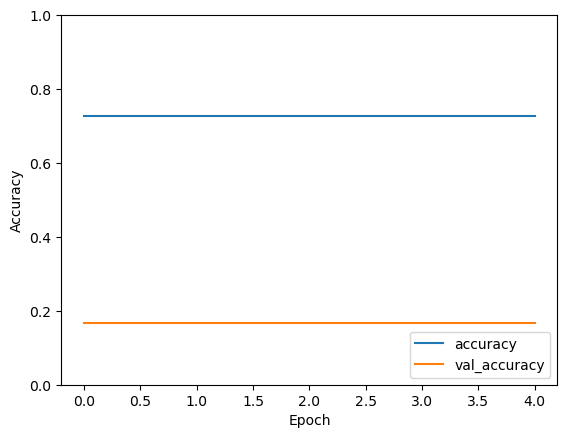

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()